In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [4]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        # Implement this!
        actions_at_St = Q[observation]
        best_action = np.argmax(actions_at_St)
        return best_action
    
    return policy_fn

In [5]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    C = defaultdict(lambda: np.zeros(env.action_space.n))

    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    # Implement this!
    for n in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (n+1) % 1000 == 0:
            print("\rEpisode {}/{}.".format(n+1, num_episodes), end="")
            sys.stdout.flush()
        
        obs = env.reset()
        G = 0.0
        W = 1.0
        
        #sample from env untill this episode finish
        episode_rewards = []
        episode_states = []
        episode_actions = []
        while True:
            episode_states.insert(0,obs)
            probs = behavior_policy(obs)
            action = np.random.choice(np.arange(len(probs)), p=probs) 
            episode_actions.insert(0,action)
            obs,reward,done,_ = env.step(action)
            episode_rewards.insert(0,reward)
            if done:
                break
                
        #see page 133 in RL book for more details
        for idx,(state,action,reward) in enumerate(zip(episode_states,episode_actions,episode_rewards)):
            G = discount_factor*G +reward
            C[state][action] += W
            Q[state][action] += W/C[state][action]*(G-Q[state][action])
            target_policy = create_greedy_policy(Q)
            if action != target_policy(state):
                break
            W = W*1.0/behavior_policy(state)[action]
            
    return Q, target_policy

In [6]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 500000/500000.

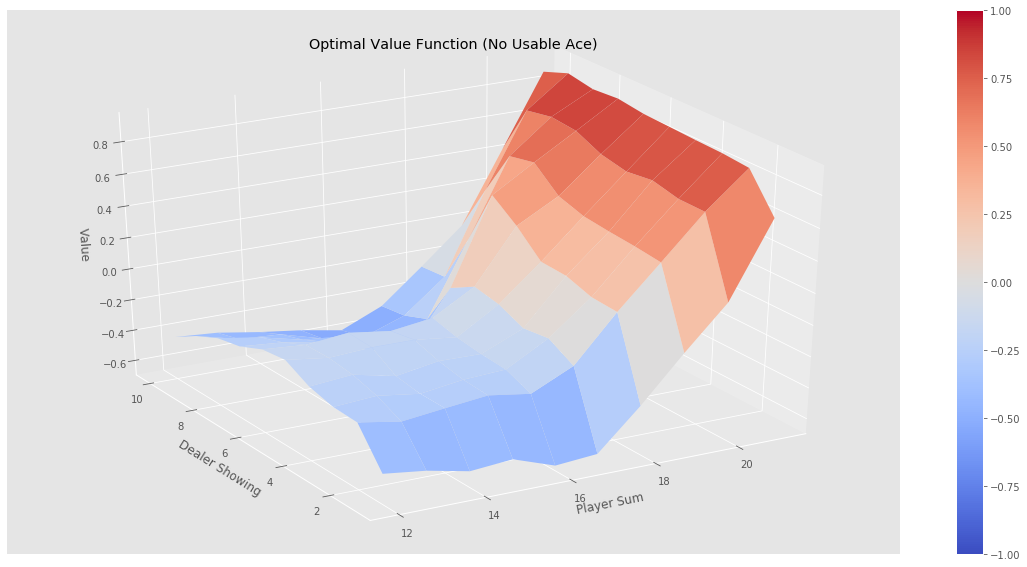

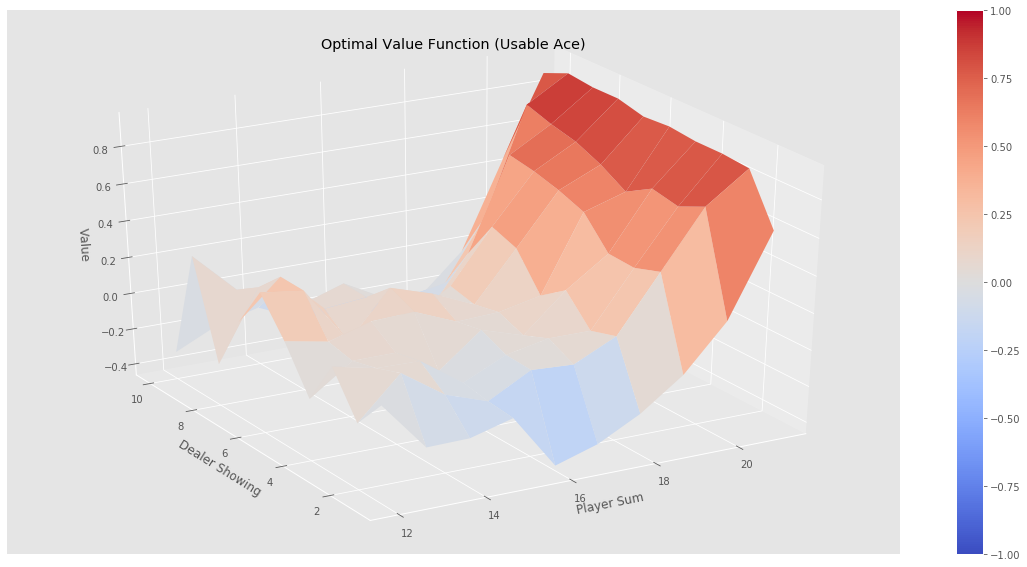

In [7]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")